<a href="https://colab.research.google.com/github/Ananya-Ahuja/Anomalyze/blob/ananya_ahuja/Data_transfer_patterns_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from sklearn.metrics import (
    precision_recall_curve, accuracy_score, precision_score,
    recall_score, f1_score, pairwise_distances_argmin_min
)
from imblearn.over_sampling import SMOTE
from tensorflow.keras import layers, models

warnings.filterwarnings('ignore')

In [4]:
# ──────────── 1. LOAD & COMBINE DATA ────────────
data_folder = '/content/datasets/'
files = glob.glob(data_folder + '*.csv')
combined_cols = [
    'uplink_volume', 'downlink_volume', 'total_volume',
    'session_duration', 'bytes_per_second', 'uplink_ratio', 'is_anomaly'
]
transfer_cols = combined_cols[:-1]

df_list = []
for f in files:
    df = pd.read_csv(f, low_memory=False)
    cols = [c for c in combined_cols if c in df.columns]
    df = df[cols]
    for c in transfer_cols:
        if c not in df:
            df[c] = pd.NA
    df = df[combined_cols]
    df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)
combined_df.dropna(subset=['uplink_volume','downlink_volume','total_volume','session_duration'], inplace=True)
print(f"Combined data shape: {combined_df.shape}")

# True labels
true_labels = combined_df['is_anomaly'].astype(int)

Combined data shape: (70000, 7)


In [5]:
# ──────────── 2. FEATURE ENGINEERING ────────────
features = combined_df[transfer_cols].astype(float).fillna(0)

# Basic ratios
features['uplink_downlink_ratio'] = features['uplink_volume'] / (features['downlink_volume'] + 1e-8)
features['volume_duration_ratio'] = features['total_volume'] / (features['session_duration'] + 1e-8)
features['bps_per_total_volume'] = features['bytes_per_second'] / (features['total_volume'] + 1e-8)

# Rolling statistics (window=5)
features['rolling_vol_mean'] = features['total_volume'].rolling(window=5, min_periods=1).mean()
features['rolling_vol_std'] = features['total_volume'].rolling(window=5, min_periods=1).std().fillna(0)

scaler = StandardScaler()
X = scaler.fit_transform(features)

In [6]:
# ──────────── 3. HANDLE CLASS IMBALANCE ────────────
X_res, y_res = SMOTE(random_state=42).fit_resample(X, true_labels)

In [7]:
# ──────────── 4. TRAIN/TEST SPLIT ────────────
X_train, X_test, y_train, y_test = train_test_split(
X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

In [8]:
# ──────────── 5. BASE UNSUPERVISED MODELS ────────────
# 5.1 Isolation Forest
iso = IsolationForest(
contamination=0.1, n_estimators=300, max_features=0.7,
random_state=42, n_jobs=-1
)
iso.fit(X_train)
iso_scores = iso.decision_function(X_test) # higher = more normal

# 5.2 K-Means distance
k2 = KMeans(n_clusters=2, random_state=42, n_init=10)
k2.fit(X_train)
_, k_dist = pairwise_distances_argmin_min(X_test, k2.cluster_centers_)

In [9]:
# ──────────── 6. ONE-CLASS SVM ────────────
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
ocsvm.fit(X_train)
svm_scores = ocsvm.decision_function(X_test) # higher = more normal

In [10]:
# ──────────── 7. AUTOENCODER ────────────
input_dim = X_train.shape[1]
inp = layers.Input(shape=(input_dim,))
enc = layers.Dense(32, activation='relu')(inp)
enc = layers.Dense(16, activation='relu')(enc)
dec = layers.Dense(32, activation='relu')(enc)
dec = layers.Dense(input_dim, activation='linear')(dec)
autoencoder = models.Model(inputs=inp, outputs=dec)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=20, batch_size=256, validation_split=0.1, verbose=0)
recon = autoencoder.predict(X_test)
ae_scores = np.mean(np.square(X_test - recon), axis=1) # higher = more anomalous

832/832 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [13]:
# ──────────── 8. ENSEMBLE & THRESHOLD TUNING ────────────
# Stack anomaly scores (invert scores where higher means more normal)
stacked = np.vstack([
    -iso_scores,
    k_dist,
    -svm_scores,
    ae_scores
]).T

best_recall = 0
best_weights = None
best_thr = None

# Grid-search weights w1..w4 summing to 1
for w1 in [0.2, 0.4, 0.6]:
    for w2 in [0.2, 0.4, 0.6]:
        for w3 in [0.2, 0.4]:
            w4 = 1.0 - (w1 + w2 + w3)
            if w4 < 0:
                continue
            ens = w1 * -iso_scores + w2 * k_dist + w3 * -svm_scores + w4 * ae_scores
            prec, rec, thr = precision_recall_curve(y_test, ens)

            # FIX: Handle the array length mismatch
            mask = prec >= 0.1
            if mask.any():
                # Use mask[:-1] to match thresholds array length
                valid_indices = np.where(mask[:-1])[0]  # Get indices where mask is True, excluding last element
                if len(valid_indices) > 0:
                    # Find the index with maximum recall among valid precision values
                    idx = valid_indices[np.argmax(rec[mask][:-1] if len(rec[mask]) > len(valid_indices) else rec[mask])]
                    r_val = rec[idx]
                    t_val = thr[idx] if idx < len(thr) else thr[-1]
                else:
                    r_val = rec.max()
                    t_val = thr[-1] if len(thr) > 0 else 0.5
            else:
                r_val = rec.max()
                t_val = thr[-1] if len(thr) > 0 else 0.5

            if r_val > best_recall:
                best_recall = r_val
                best_weights = (w1, w2, w3, w4)
                best_thr = t_val

print(f"Best weights (ISO,KMeans,SVM,AE): {best_weights}, threshold: {best_thr:.4f}")

final_score = (
    best_weights[0] * -iso_scores +
    best_weights[1] * k_dist +
    best_weights[2] * -svm_scores +
    best_weights[3] * ae_scores
)
final_pred = (final_score >= best_thr).astype(int)

Best weights (ISO,KMeans,SVM,AE): (0.2, 0.2, 0.2, 0.3999999999999999), threshold: -3.2472


=== FINAL MODEL PERFORMANCE ===
Accuracy: 0.500
Precision: 0.500
Recall: 1.000
F1 Score: 0.667

=== FORENSIC-SPECIFIC METRICS ===
False Negatives: 0
Total Anomalies: 13300
False Negative Rate:0.000
Detection Rate: 1.000


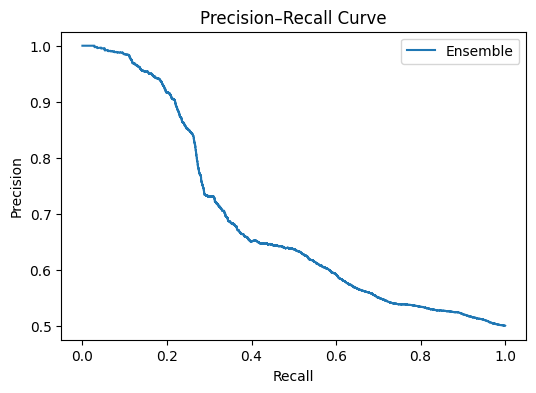

In [14]:
# ──────────── 9. EVALUATION & REPORT ────────────
acc = accuracy_score(y_test, final_pred)
prec = precision_score(y_test, final_pred)
rec = recall_score(y_test, final_pred)
f1 = f1_score(y_test, final_pred)
fn = ((y_test == 1) & (final_pred == 0)).sum()
tot = (y_test == 1).sum()

print("=== FINAL MODEL PERFORMANCE ===")
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1 Score: {f1:.3f}")

print("\n=== FORENSIC-SPECIFIC METRICS ===")
print(f"False Negatives: {fn}")
print(f"Total Anomalies: {tot}")
print(f"False Negative Rate:{fn/tot:.3f}")
print(f"Detection Rate: {1 - fn/tot:.3f}")

# Precision–Recall Curve
p, r, _ = precision_recall_curve(y_test, final_score)
plt.figure(figsize=(6,4))
plt.plot(r, p, label='Ensemble')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(); plt.show()

In [ ]:
# ──────────── 10. SAVE RESULTS ────────────
output_df = combined_df.iloc[y_test.index].copy()
output_df['final_anomaly'] = final_pred
output_df.to_csv('/content/enhanced_anomaly_results.csv', index=False)
print("Results saved to /content/enhanced_anomaly_results.csv")